In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeshprasadpaudel","key":"74d1fc40a1c6a15f2766cf2b4e79b5f7"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                          title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                   Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           2235         46  1.0              
mmohaiminulislam/ecommerce-data-analysis                     ECommerce Data Analysis                      17MB  2024-01-01 02:04:35            921         23  1.0              
thedrcat/daigt-v2-train-dataset                              DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           3515        284  1.0              
marouandaghmoumi/dropout-and-success-student-data-analysis   Dropout and Success: Student Data Analysis   87KB  202

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:18<00:00, 242MB/s]
100% 2.29G/2.29G [00:18<00:00, 130MB/s]


In [6]:
! ls

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [7]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from tensorflow import keras

In [9]:
train_normal = glob.glob('/content/chest_xray/train/NORMAL/*jpeg')
test_normal = glob.glob('/content/chest_xray/test/NORMAL/*jpeg')
val_normal = glob.glob('/content/chest_xray/val/NORMAL/*jpeg')
train_pneu = glob.glob('/content/chest_xray/train/PNEUMONIA/*jpeg')
test_pneu = glob.glob('/content/chest_xray/test/PNEUMONIA/*jpeg')
val_pneu = glob.glob('/content/chest_xray/val/PNEUMONIA/*jpeg')

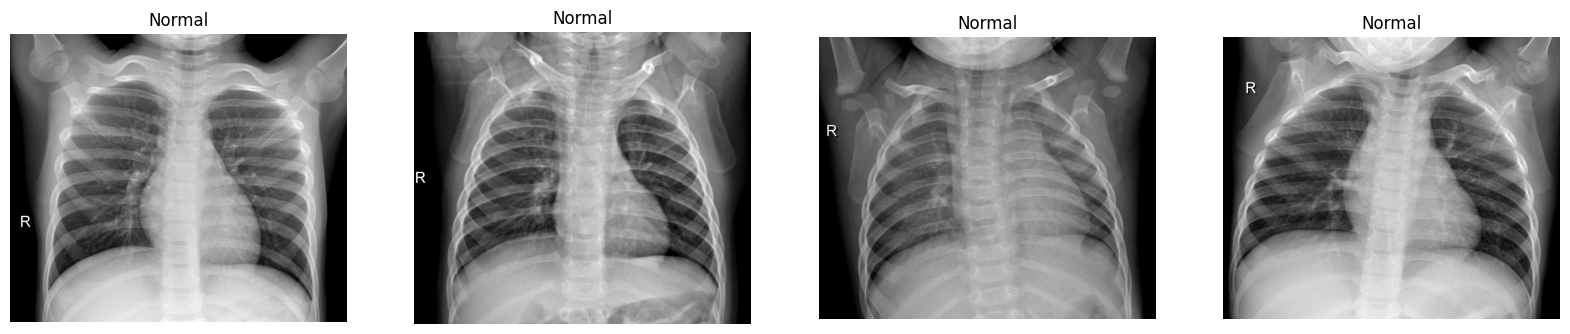

In [15]:
plt.figure(figsize=(20,4))
for i in enumerate(train_normal[0:4]):
    plt.subplot(1,4,i[0]+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title('Normal')

In [1]:
plt.figure(figsize=(20,4))
for i in enumerate(train_pneu[0:4]):
    plt.subplot(1,4,i[0]+1)
    plt.axis('off')
    image = plt.imread(i[1])
    plt.imshow(image, cmap='gray')
    plt.title('Pneumonia')

NameError: name 'plt' is not defined